# classification-05

## What's new:

1- https://chatgpt.com/c/68ffabef-fdfc-8330-9587-d4710aaa2658

## next step:

1- Improve labeling ( 3333 from 28-1111 )


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape, TimeDistributed, Lambda, RepeatVector

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, callbacks
import talib


In [2]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# ensure strings and strip any weird whitespace
df['DATE'] = df['DATE'].astype(str).str.strip()
df['TIME'] = df['TIME'].astype(str).str.strip()

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], dayfirst=False, errors='coerce')
if df['DATETIME'].isna().any():
    raise ValueError("Some DATETIME values could not be parsed. Check date/time formats.")

# set DATETIME as index for reindexing
df = df.set_index('DATETIME').sort_index()

# --------------------------
# Create continuous hourly index & fill weekend gaps
# --------------------------
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindex to full hourly range so weekends/missing hours appear as NaN rows
df = df.reindex(full_index)

# Fill strategy:
# - Prices: forward-fill last known price across weekend gap (common approach for modeling continuity).
# - TICKVOL / VOL: set missing to 0 (no ticks during weekend).
# - SPREAD: forward-fill last known.
# Alternative: you could leave NaNs and drop sequences that cross weekends (safer but reduces data).
df[['OPEN', 'HIGH', 'LOW', 'CLOSE']] = df[['OPEN', 'HIGH', 'LOW', 'CLOSE']].ffill()
df['SPREAD'] = df['SPREAD'].ffill()
df['TICKVOL'] = df['TICKVOL'].fillna(0)
df['VOL'] = df['VOL'].fillna(0)

# Reset index to make DATETIME a regular column again
df = df.reset_index().rename(columns={'index': 'DATETIME'})

In [3]:
df.shape

(179856, 10)

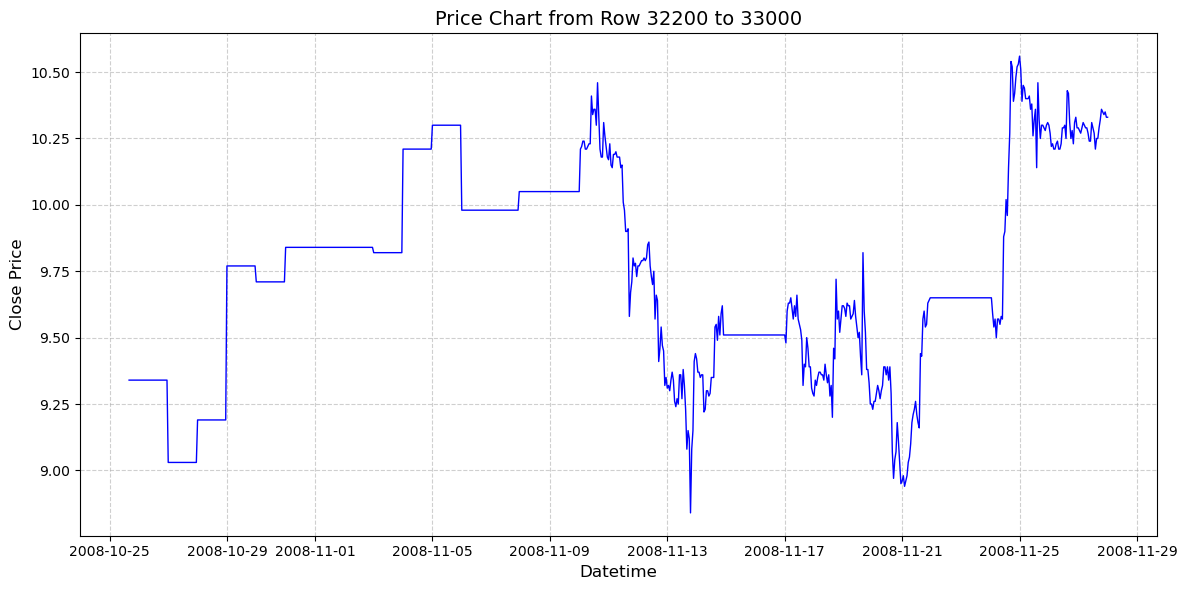

In [4]:
import matplotlib.pyplot as plt

# Example: choose the start and end rows
start_row = 32200
end_row = 33000

# Select the range and make a copy to avoid SettingWithCopyWarning
subset = df.iloc[start_row:end_row + 1].copy()

# Ensure DATETIME is datetime type
subset['DATETIME'] = pd.to_datetime(subset['DATETIME'])

# Plot CLOSE price over time
plt.figure(figsize=(12, 6))
plt.plot(subset['DATETIME'], subset['CLOSE'], linewidth=1.0, color='blue')

# Labels and formatting
plt.title(f"Price Chart from Row {start_row} to {end_row}", fontsize=14)
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [5]:
# Specify how many rows to remove for model
nn = 33000  # Delete the first nn rows that do not follow the one-hour timeframe.
mm = 500  # Remove mm last row that the model should not see.

# Delete first nn and last mm rows
df_model = df.iloc[nn:len(df) - mm].reset_index(drop=True)

In [6]:
def label_reversal_points(prices, window=6, threshold=0.0007):
    """
    Labels trend reversals (1=Buy, 2=Sell) based on local mean shifts.
    Smaller window & threshold increase sensitivity.
    """
    prices = np.asarray(prices)
    labels = [0] * len(prices)
    prev_trend = 0  # 1 = up, -1 = down, 0 = unknown

    for i in range(len(prices) - window):
        past = prices[i:i + window // 2]
        future = prices[i + window // 2:i + window]

        past_mean = np.mean(past)
        future_mean = np.mean(future)
        change = (future_mean - past_mean) / past_mean

        if change > threshold:
            curr_trend = 1  # Uptrend
        elif change < -threshold:
            curr_trend = -1  # Downtrend
        else:
            curr_trend = 0  # No significant trend

        # Detect reversal only when trend flips clearly
        if prev_trend == -1 and curr_trend == 1:
            labels[i + window // 2] = 1  # Buy
        elif prev_trend == 1 and curr_trend == -1:
            labels[i + window // 2] = 2  # Sell

        if curr_trend != 0:
            prev_trend = curr_trend

    return labels


df_model['Label'] = label_reversal_points(df_model['CLOSE'].values)

In [7]:
print(df_model['Label'].value_counts().sort_index())  # 0, 1, 2

Label
0    130688
1      7834
2      7834
Name: count, dtype: int64


In [8]:
import matplotlib.pyplot as plt


def plot_labeled_candles(df, n=190):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    Assumes df already has a 'DATETIME' column.
    """
    # Drop NaN rows (e.g., weekend gaps)
    df_plot = df.dropna(subset=['CLOSE']).tail(n).copy()

    # Ensure DATETIME is a datetime column (optional safeguard)
    if not pd.api.types.is_datetime64_any_dtype(df_plot['DATETIME']):
        df_plot['DATETIME'] = pd.to_datetime(df_plot['DATETIME'])

    # === Plot Close Price ===
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # === Plot BUY (1) and SELL (2) signals ===
    for _, row in df_plot.iterrows():
        if row['Label'] == 1:  # BUY
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:  # SELL
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    # === Aesthetics ===
    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()



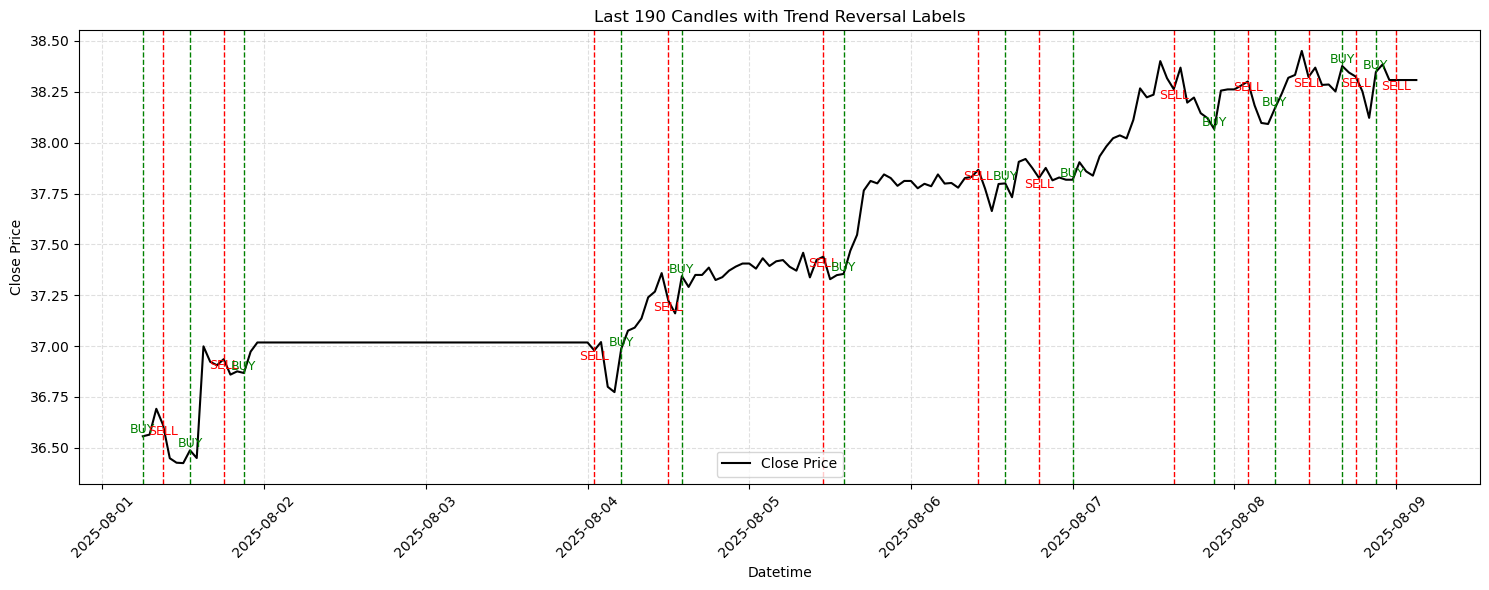

In [9]:
plot_labeled_candles(df_model)

In [10]:
from collections import Counter

# User parameters (you provided)
WINDOW_SIZE = 60
FORECAST_HORIZON = 10
FEATURES = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']
NUM_CLASSES = 3  # 0,1,2

# Training hyperparameters (tweak as needed)
LEARNING_RATE = 1e-3
VALIDATION_SPLIT_RATIO = 0.1  # portion of training time-series reserved for validation after temporal split
TEST_SPLIT_RATIO = 0.1  # final hold-out test set (temporal)
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [11]:
# === 0. Sanity checks + minimal preprocessing ===
# Assumes df_model exists in the workspace and has DATETIME (datetime-like) and Label columns
assert 'DATETIME' in df_model.columns, "df_model must already contain 'DATETIME' column"
assert 'Label' in df_model.columns, "df_model must already contain 'Label' column"

# Ensure DATETIME is datetime dtype and sorted
df_model['DATETIME'] = pd.to_datetime(df_model['DATETIME'])
df_model = df_model.sort_values('DATETIME').reset_index(drop=True)

# Optional: fill small NaNs in FEATURES if any (shouldn't be necessary if you've cleaned dataset)
df_model[FEATURES] = df_model[FEATURES].ffill().bfill()


In [12]:
# === 1. Add time features to help the model learn holidays/weekends/seasonality ===
# These are continuous/cyclical features — they let model learn patterns like weekends/holidays that
# are periodic in time. Since dataset is continuous (includes holidays), these help model detect those.
df_model['hour'] = df_model['DATETIME'].dt.hour
df_model['dow'] = df_model['DATETIME'].dt.weekday  # 0=Mon .. 6=Sun
df_model['dayofyear'] = df_model['DATETIME'].dt.dayofyear

# cyclical transforms
df_model['hour_sin'] = np.sin(2 * np.pi * df_model['hour'] / 24.0)
df_model['hour_cos'] = np.cos(2 * np.pi * df_model['hour'] / 24.0)
df_model['dow_sin'] = np.sin(2 * np.pi * df_model['dow'] / 7.0)
df_model['dow_cos'] = np.cos(2 * np.pi * df_model['dow'] / 7.0)
df_model['dayofyear_sin'] = np.sin(2 * np.pi * df_model['dayofyear'] / 365.25)
df_model['dayofyear_cos'] = np.cos(2 * np.pi * df_model['dayofyear'] / 365.25)

# Extend FEATURES to include these engineered time-features
ADDITIONAL = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'dayofyear_sin', 'dayofyear_cos']
ALL_FEATURES = FEATURES + ADDITIONAL


In [13]:
# === 2. Create sliding windows and horizon labels ===
# For each time t we will create input X = rows [t-WINDOW_SIZE+1 ... t] (length WINDOW_SIZE)
# and label Y = Label at times [t+1 ... t+FORECAST_HORIZON] (the next FORECAST_HORIZON hours)
# We will discard windows that cannot produce a full horizon.

def make_windows_and_labels(df, feature_cols, label_col='Label',
                            window_size=WINDOW_SIZE, horizon=FORECAST_HORIZON):
    X_list = []
    y_list = []
    dt_index = []  # store the last timestamp of the input window (for later reference)
    n = len(df)
    # iterate t = index of last row in the input window
    for t in range(window_size - 1, n - horizon):
        x_block = df.iloc[t - (window_size - 1): t + 1][feature_cols].values  # shape (window_size, n_features)
        y_block = df.iloc[t + 1: t + 1 + horizon][label_col].astype(int).values  # shape (horizon,)
        X_list.append(x_block)
        y_list.append(y_block)
        dt_index.append(df['DATETIME'].iloc[t])  # last input timestamp
    X = np.asarray(X_list, dtype=np.float32)
    y = np.asarray(y_list, dtype=np.int32)
    return X, y, np.array(dt_index)


X_all, y_all, dt_all = make_windows_and_labels(df_model, ALL_FEATURES, 'Label',
                                               window_size=WINDOW_SIZE, horizon=FORECAST_HORIZON)
print(f"Total samples created: {X_all.shape[0]}, X shape: {X_all.shape}, y shape: {y_all.shape}")


Total samples created: 146287, X shape: (146287, 60, 11), y shape: (146287, 10)


In [14]:
# === 3. Temporal train/val/test split (no leakage) ===
# We'll keep last TEST_SPLIT_RATIO of chronologically ordered samples as test set (hold-out).
n_samples = X_all.shape[0]
n_test = int(np.ceil(TEST_SPLIT_RATIO * n_samples))
n_trainval = n_samples - n_test

X_trainval = X_all[:n_trainval]
y_trainval = y_all[:n_trainval]
dt_trainval = dt_all[:n_trainval]

X_test = X_all[n_trainval:]
y_test = y_all[n_trainval:]
dt_test = dt_all[n_trainval:]

# Now split trainval into train and validation chronologically as well
n_val = int(np.ceil(VALIDATION_SPLIT_RATIO * X_trainval.shape[0]))
n_train = X_trainval.shape[0] - n_val

X_train = X_trainval[:n_train]
y_train = y_trainval[:n_train]
dt_train = dt_trainval[:n_train]

X_val = X_trainval[n_train:]
y_val = y_trainval[n_train:]
dt_val = dt_trainval[n_train:]

print("Train / Val / Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])


Train / Val / Test sizes: 118492 13166 14629


In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
# === 4. Scale features: fit scaler on train only, apply to val/test ===
# scaler expects 2D, so we reshape windows to (n_samples * window_size, n_features) and inverse reshape
n_features = len(ALL_FEATURES)
scaler = StandardScaler()
X_train_2d = X_train.reshape(-1, n_features)
scaler.fit(X_train_2d)

def scale_windows(X, scaler):
    n_s, w, nf = X.shape
    X2 = X.reshape(-1, nf)
    X2 = scaler.transform(X2)
    return X2.reshape(n_s, w, nf)

X_train_s = scale_windows(X_train, scaler)
X_val_s = scale_windows(X_val, scaler)
X_test_s = scale_windows(X_test, scaler)


In [17]:
# === 5. Deal with class imbalance ===
# We'll produce:
#  - y_train_cat: one-hot categorical targets (n_samples, horizon, num_classes)
#  - sample_weight_train: per-sample-per-timestep weights (n_samples, horizon)
#
# Strategy:
#  - Compute global class frequencies across train set (across all timesteps in horizon)
#  - Set class_weight = total_samples / (num_classes * class_count)  (sklearn-style)
#  - Build sample_weights_train by mapping each (sample, timestep) label -> class_weight[label]
#  - Also lightly upsample windows that contain any non-zero label (i.e., signal windows)
#    to increase minority representation (repeat them a few times). This is cheap and avoids
#    complex time-series resampling algorithms.

def build_temporal_sample_weights(y, num_classes=NUM_CLASSES):
    # y shape (n_samples, horizon)
    flat = y.flatten()
    counts = Counter(flat.tolist())
    total = len(flat)
    # class_weights: inverse-frequency
    class_weights = {c: (total / (num_classes * counts.get(c, 1))) for c in range(num_classes)}
    # build per-sample-per-timestep weight matrix
    weights = np.vectorize(lambda label: class_weights[int(label)])(y)
    return weights, class_weights

# compute weights on training set
sample_weights_train, class_weights = build_temporal_sample_weights(y_train, NUM_CLASSES)
print("Class weights (computed from train):", class_weights)

# Optional light upsampling of minority windows in train set:
# find indices of windows that contain any signal (label != 0 in their future horizon)
signal_mask = (y_train != 0).any(axis=1)
n_signal = signal_mask.sum()
n_non_signal = (~signal_mask).sum()
print("Signal windows:", n_signal, "Non-signal windows:", n_non_signal)

# compute an upsample factor such that signal windows make up at most ~30-40% of train set
target_signal_fraction = 0.35
if n_signal > 0:
    desired_signal_count = int(target_signal_fraction * X_train_s.shape[0])
    if desired_signal_count > n_signal:
        # replicate signal indices
        rep = int(np.ceil(desired_signal_count / n_signal)) - 1  # how many extra copies
        if rep > 0:
            idx_signal = np.where(signal_mask)[0]
            X_signal = X_train_s[idx_signal]
            y_signal = y_train[idx_signal]
            sw_signal = sample_weights_train[idx_signal]
            # replicate
            X_train_s = np.concatenate([X_train_s] + [X_signal] * rep, axis=0)
            y_train = np.concatenate([y_train] + [y_signal] * rep, axis=0)
            sample_weights_train = np.concatenate([sample_weights_train] + [sw_signal] * rep, axis=0)
            print(f"Upsampled signal windows by factor {rep+1}. New train size: {X_train_s.shape[0]}")
else:
    print("No signal windows found in train (unexpected). Proceeding without upsampling.")


Class weights (computed from train): {0: 0.3734760517921757, 1: 6.202470686767169, 2: 6.202470686767169}
Signal windows: 74853 Non-signal windows: 43639


In [18]:
# === 6. Convert labels to categorical one-hot for Keras ===
# y_train/y_val/y_test shape: (n_samples, horizon) with ints 0..2
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)  # shape (n, horizon, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

# Make sure sample_weights_train matches current X_train_s length
if sample_weights_train.shape[0] != X_train_s.shape[0]:
    # If we upsampled, sample_weights_train already expanded above.
    # But if mismatch persists, recompute from y_train
    sample_weights_train, class_weights = build_temporal_sample_weights(y_train, NUM_CLASSES)

print("Shapes: X_train_s:", X_train_s.shape, "y_train_cat:", y_train_cat.shape,
      "sample_weights_train:", sample_weights_train.shape)


Shapes: X_train_s: (118492, 60, 11) y_train_cat: (118492, 10, 3) sample_weights_train: (118492, 10)


In [19]:
# === 7. Build Seq2Seq LSTM model that outputs categorical predictions per horizon timestep ===
# Encoder-decoder LSTM: encode WINDOW_SIZE -> latent -> RepeatVector(FORECAST_HORIZON) -> decoder LSTM -> TimeDistributed(Dense(NUM_CLASSES, softmax))

def build_seq2seq_model(window_size=WINDOW_SIZE, n_features=len(ALL_FEATURES),
                        horizon=FORECAST_HORIZON, num_classes=NUM_CLASSES, lr=LEARNING_RATE):
    inp = layers.Input(shape=(window_size, n_features), name='input_window')
    # encoder
    x = layers.Masking(mask_value=0.0)(inp)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.05))(x)
    x = layers.Dense(64, activation='relu')(x)
    # repeat and decode
    x = layers.RepeatVector(horizon)(x)
    x = layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.05)(x)
    # optionally add attention style layer (simple self-attention-like block)
    # but keep it simple and stable:
    x = layers.TimeDistributed(layers.Dense(64, activation='relu'))(x)
    out = layers.TimeDistributed(layers.Dense(num_classes, activation='softmax'), name='out')(x)

    model = models.Model(inputs=inp, outputs=out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    # IMPORTANT: specify sample_weight_mode='temporal' because we'll pass 2D sample weights (n_samples, horizon)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  run_eagerly=False)  # keep graph mode
    return model

model = build_seq2seq_model()
model.summary(line_length=120)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_window (InputLayer)         │ (None, 60, 11)               │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ not_equal (NotEqual)              │ (None, 60, 11)               │                 0 │ input_window[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ masking (Masking)                 │ (None, 60, 11)               │                 0 │ input_window[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ any (Any)                         │ (None, 60)                   │                 0 │ not_equal[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ bidirectional (Bidirectional)     │ (None, 256)                  │           143,360 │ masking[0][0], any[0][0]  
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense (Dense)                     │ (None, 64)                   │            16,448 │ bidirectional[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ repeat_vector (RepeatVector)      │ (None, 10, 64)               │                 0 │ dense[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ lstm_1 (LSTM)                     │ (None, 10, 64)               │            33,024 │ repeat_vector[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ time_distributed                  │ (None, 10, 64)               │             4,160 │ lstm_1[0][0]              
│ (TimeDistributed)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ out (TimeDistributed)             │ (None, 10, 3)                │               195 │ time_distributed[0][0]    
└───────────────────────────────────┴──────────────────────────────┴───────────────────┴───────────────────────────

 Total params: 197,187 (770.26 KB)

 Trainable params: 197,187 (770.26 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# === 8. Callbacks ===
cb_early = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
cb_chk = callbacks.ModelCheckpoint('best_seq2seq_model.keras', monitor='val_loss', save_best_only=True)
cb_reduce = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)


In [ ]:
# === 9. Fit the model ===
# Keras expects sample_weight to be either (n_samples,) or (n_samples, horizon) if you supply temporal weights
# We'll provide sample_weights_train (n_samples, horizon). For validation, we can pass sample weights or omit them.
# Note: when sample_weight is 2D (temporal), you must set model.sample_weight_mode='temporal' (Keras infers).
#
# Convert to float32
sw_train = sample_weights_train.astype(np.float32)

history = model.fit(
    X_train_s,                    # shape (n_train, window, n_features)
    y_train_cat,                  # shape (n_train, horizon, num_classes)
    sample_weight=sw_train,       # shape (n_train, horizon)
    validation_data=(X_val_s, y_val_cat),
    epochs=60,
    batch_size=128,
    callbacks=[cb_early, cb_chk, cb_reduce],
    verbose=2
)


In [22]:
# === Prediction pipeline: create predicted_df for given_time ===

import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Input from you:
given_time = "2025.07.24 11:00:00"  # note: space, not tab
# ensure format string matches "YYYY.MM.DD HH:MM:SS"
_given_fmt = "%Y.%m.%d %H:%M:%S"

# --- Sanity checks: required names from training environment ---
_required_names = {
    'df_model': 'your continuous dataframe with DATETIME column',
    'ALL_FEATURES': 'list of feature column names used during training',
    'WINDOW_SIZE': 'window size used during training (60)',
    'FORECAST_HORIZON': 'forecast horizon used during training (10)',
    'scaler': 'StandardScaler fitted on training data',
    'model': 'trained Keras model (seq2seq) that outputs (batch, horizon, num_classes)'
}
missing = [name for name in _required_names if name not in globals()]
if missing:
    raise RuntimeError(f"Missing required objects in notebook environment: {missing}. "
                       f"Make sure you ran the training/preprocessing cells first.")

# parse time
try:
    given_dt = datetime.strptime(given_time, _given_fmt)
except Exception as e:
    raise ValueError(f"given_time string not parseable with format {_given_fmt}: {e}")

# ensure df_model.DATETIME is datetime and sorted (we assume training steps already ensured this)
if not np.issubdtype(df_model['DATETIME'].dtype, np.datetime64):
    df_model['DATETIME'] = pd.to_datetime(df_model['DATETIME'])
df_model = df_model.sort_values('DATETIME').reset_index(drop=True)

# find the index of the last available candle at or before given_dt
cands = df_model[df_model['DATETIME'] <= pd.Timestamp(given_dt)]
if len(cands) == 0:
    raise ValueError(f"No rows in df_model with DATETIME <= {given_dt}. Check dataset or given_time.")
last_row = cands.iloc[-1]
last_idx = last_row.name if hasattr(last_row, 'name') else cands.index[-1]
# in case reset_index changed .name, compute index position:
last_pos = cands.index[-1]  # position in df_model index

# ensure we have enough prior rows for WINDOW_SIZE
start_pos = last_pos - (WINDOW_SIZE - 1)
if start_pos < 0:
    raise ValueError(f"Not enough historic candles before {given_dt}. Need WINDOW_SIZE={WINDOW_SIZE} rows, "
                     f"but only {last_pos+1} available up to that time.")

# slice the input window (inclusive of the last candle)
window_df = df_model.iloc[start_pos : last_pos + 1].copy()
if window_df.shape[0] != WINDOW_SIZE:
    raise RuntimeError(f"Extracted window length {window_df.shape[0]} != WINDOW_SIZE {WINDOW_SIZE}")

# Prepare the features in the same order as training (ALL_FEATURES)
missing_feats = [f for f in ALL_FEATURES if f not in window_df.columns]
if missing_feats:
    raise RuntimeError(f"Missing feature columns in df_model/window: {missing_feats}")

X_window = window_df[ALL_FEATURES].values.astype(np.float32)  # shape (WINDOW_SIZE, n_features)
# scale using training scaler (scaler must be fitted on train data)
n_features = X_window.shape[1]
X_window_scaled = scaler.transform(X_window.reshape(-1, n_features)).reshape(1, WINDOW_SIZE, n_features)

# Predict probabilities for next FORECAST_HORIZON timesteps
probs = model.predict(X_window_scaled)  # shape (1, horizon, num_classes)
if probs.ndim != 3 or probs.shape[1] != FORECAST_HORIZON:
    raise RuntimeError(f"Unexpected model output shape: {probs.shape}. Expected (1, {FORECAST_HORIZON}, num_classes)")

probs = probs[0]  # shape (horizon, num_classes)
pred_labels = np.argmax(probs, axis=-1).astype(int)  # shape (horizon,)

# Build future timestamps: the forecast hours immediately after the last input candle
# The dataset timeframe is 1-hour candles, so next timestamps are last_datetime + 1h .. +FORECAST_HORIZON h
last_timestamp = pd.Timestamp(df_model.iloc[last_pos]['DATETIME'])
future_timestamps = [last_timestamp + timedelta(hours=i+1) for i in range(FORECAST_HORIZON)]

# Build predicted_df
predicted_df = pd.DataFrame({
    'DATETIME': future_timestamps,
    'pred_label': pred_labels
})

# also attach per-class probabilities for transparency
n_classes = probs.shape[1]
for c in range(n_classes):
    predicted_df[f'prob_{c}'] = probs[:, c]

# reset index for neatness
predicted_df = predicted_df.reset_index(drop=True)

# Output variable expected by you
predicted_df


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


2025-10-28 09:48:17.644057: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


,DATETIME,pred_label,prob_0,prob_1,prob_2
0,2025-07-24 12:00:00,1,0.242384,0.397598,0.360018
1,2025-07-24 13:00:00,1,0.238910,0.401633,0.359456
2,2025-07-24 14:00:00,1,0.239025,0.401229,0.359746
3,2025-07-24 15:00:00,1,0.240030,0.400026,0.359943
4,2025-07-24 16:00:00,1,0.240712,0.398961,0.360327
5,2025-07-24 17:00:00,1,0.241383,0.397941,0.360675
6,2025-07-24 18:00:00,1,0.242001,0.397006,0.360993
7,2025-07-24 19:00:00,1,0.242571,0.396237,0.361193
8,2025-07-24 20:00:00,1,0.243089,0.395530,0.361381
9,2025-07-24 21:00:00,1,0.243565,0.394880,0.361555


# plot section

In [23]:
# --------------------------
# === Visualization Block ===
# --------------------------
import pandas as pd
import sys
from datetime import timedelta

# --- 1. Historical window (last 4 real candles before forecast) ---
# The last candle in the 60-candle input window corresponds to given_time
last_input_time = pd.Timestamp(given_dt)
start_hist_time = last_input_time - timedelta(hours=3)  # 4 candles including the last one
historical_df = df_model[
    (df_model['DATETIME'] >= start_hist_time) &
    (df_model['DATETIME'] <= last_input_time)
][['DATETIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'Label']].copy()

# --- 2. Actual future 10 candles ---
# These are the ground-truth future 10 candles immediately after given_time
start_future_time = last_input_time + timedelta(hours=1)
end_future_time = last_input_time + timedelta(hours=FORECAST_HORIZON)
actual_future_df = df_model[
    (df_model['DATETIME'] >= start_future_time) &
    (df_model['DATETIME'] <= end_future_time)
][['DATETIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'Label']].copy()

# --- 3. Create predicted_df (forecast for next 10 hours) ---
# We assume predicted_df has already been created by your prediction pipeline.
# Just ensure columns are standardized for plotting:
predicted_df = predicted_df.copy()
predicted_df['Label'] = predicted_df['pred_label']
predicted_df = predicted_df[['DATETIME', 'Label', 'prob_0', 'prob_1', 'prob_2']]

# --- 4. Add text labels for clarity ---
def class_to_label(c):
    if c == 1:
        return 'buy'
    elif c == 2:
        return 'sell'
    else:
        return None

# Apply text label to all dataframes (for plotting markers/text)
historical_df['Signal'] = historical_df['Label'].apply(class_to_label)
actual_future_df['Signal'] = actual_future_df['Label'].apply(class_to_label)
predicted_df['Signal'] = predicted_df['Label'].apply(class_to_label)

# --- 5. Plot title & output settings ---
plot_title = 'Actual vs Predicted Forex Trend Reversals'
output_plot_path = None  # e.g., 'forecast_plot.png'


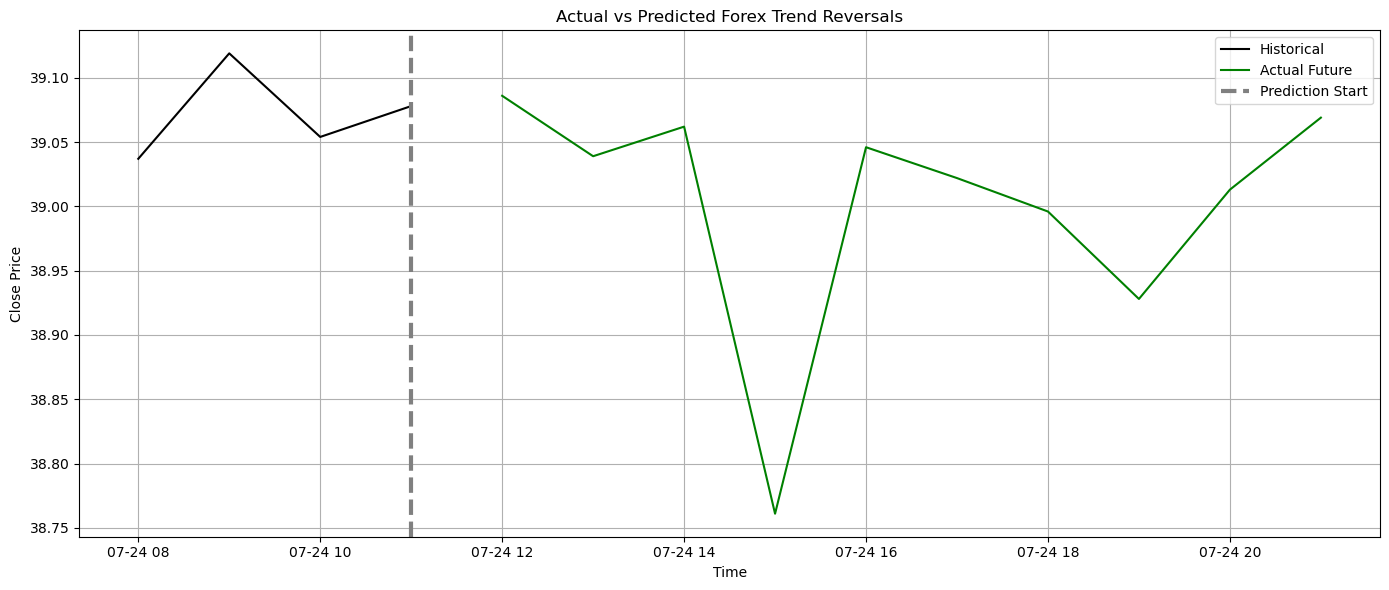

In [24]:
# --- 6. Import your plotting utility ---
sys.path.insert(1, '../utils')
import forex_plot_utils_2

# --- 7. Plot all series ---
forex_plot_utils_2.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)


In [ ]:
# 11- Save Model

from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
model.save(model_path)

# 11-4 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# 11-6 Save model summary and final performance
y_test_onehot = to_categorical(y_test, num_classes=3)

with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)

    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
    f.write(f'Final Test Accuracy: {final_test_accuracy:.6f}\n')

In [21]:
from tensorflow import keras

model = keras.models.load_model(
    'saved_models/model_20251027_214205.keras',
    safe_mode=False
)
